In [96]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [11]:
!pip install plotly

You should consider upgrading via the 'c:\python\python.exe -m pip install --upgrade pip' command.


In [97]:
# отрисовка гарфика

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [98]:
dataset = pd.read_csv('hour_online.csv', index_col=['Time'], parse_dates=['Time'])
plotly_df(dataset, title = "Online users")
#dataset.head

## Скользящее среднее

$$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$$

In [99]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(dataset.Users, 24)

29858.333333333332

К сожалению, такой прогноз долгосрочным сделать не удастся — для получения предсказания на шаг вперед предыдущее значение должно быть фактически наблюдаемой величиной. Зато у скользящей средней есть другое применение — сглаживание исходного ряда для выявления трендов. В пандасе есть готовая реализация — DataFrame.rolling(window).mean(). Чем больше зададим ширину интервала — тем более сглаженным окажется тренд. 

In [100]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(dataset[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

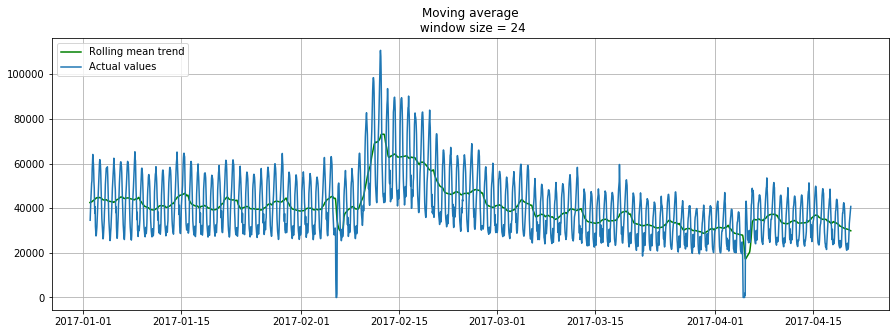

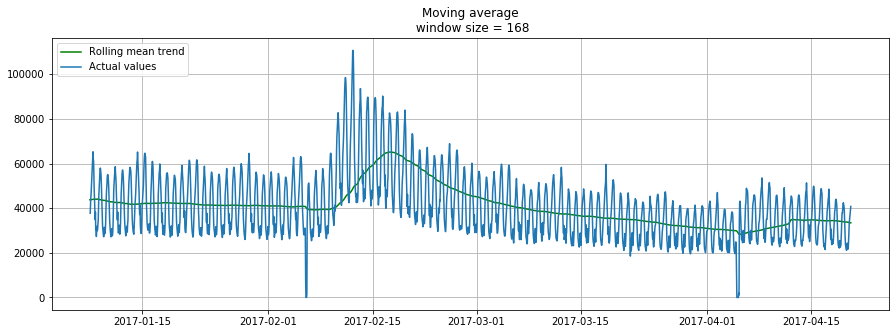

In [101]:
plotMovingAverage(dataset, 24) # сглаживаем по дням
plotMovingAverage(dataset, 24*7) # сглаживаем по неделям

Модификацией простой скользящей средней является взвешенная средняя, внутри которой наблюдениям придаются различные веса, в сумме дающие единицу, при этом обычно последним наблюдениям присваивается больший вес.


$$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$$

In [102]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

weighted_average(dataset.Users, [0.6, 0.2, 0.1, 0.07, 0.03])

35967.55

## Простое экспоненциальное сглаживание
$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1}$$

In [103]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

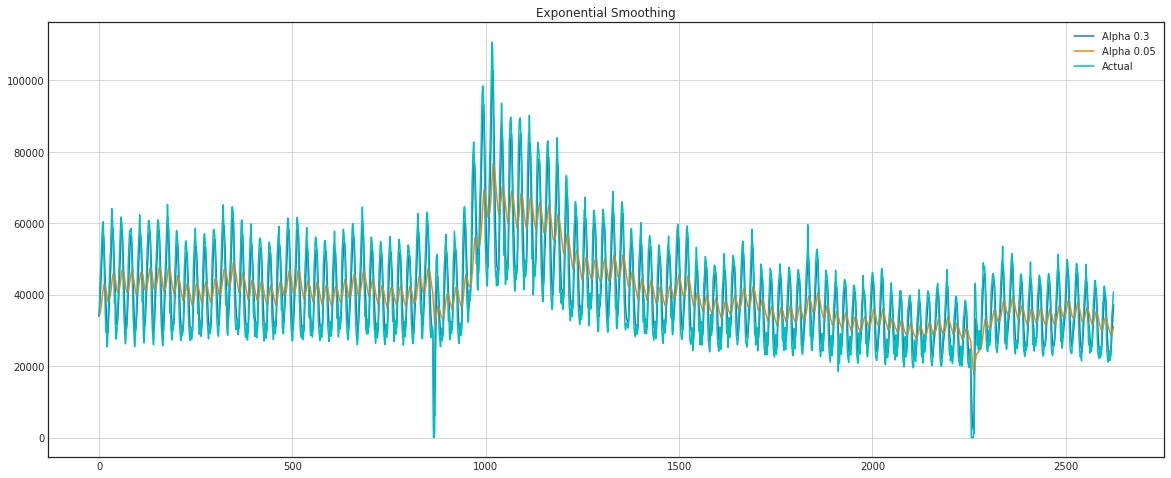

In [104]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(dataset.Users, alpha), label="Alpha {}".format(alpha))
    plt.plot(dataset.Users.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

## Двойное экспоненциальное сглаживание

До сих пор мы могли получить от наших методов в лучшем случае прогноз лишь на одну точку вперёд (и ещё красиво сгладить ряд), это здорово, но недостаточно, поэтому переходим к расширению экспоненциального сглаживания, которое позволит строить прогноз сразу на две точки вперед (и тоже красиво сглаживать ряд).


В этом нам поможет разбиение ряда на две составляющие — уровень (level, intercept) $\ell$ и тренд $b$ (trend, slope). Уровень, или ожидаемое значение ряда, мы предсказывали при помощи предыдущих методов, а теперь такое же экспоненциальное сглаживание применим к тренду, наивно или не очень полагая, что будущее направление изменения ряда зависит от взвешенных предыдущих изменений.


$$ \ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})\\ b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}\\ \hat{y}_{x+1} = \ell_x + b_x $$

In [105]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

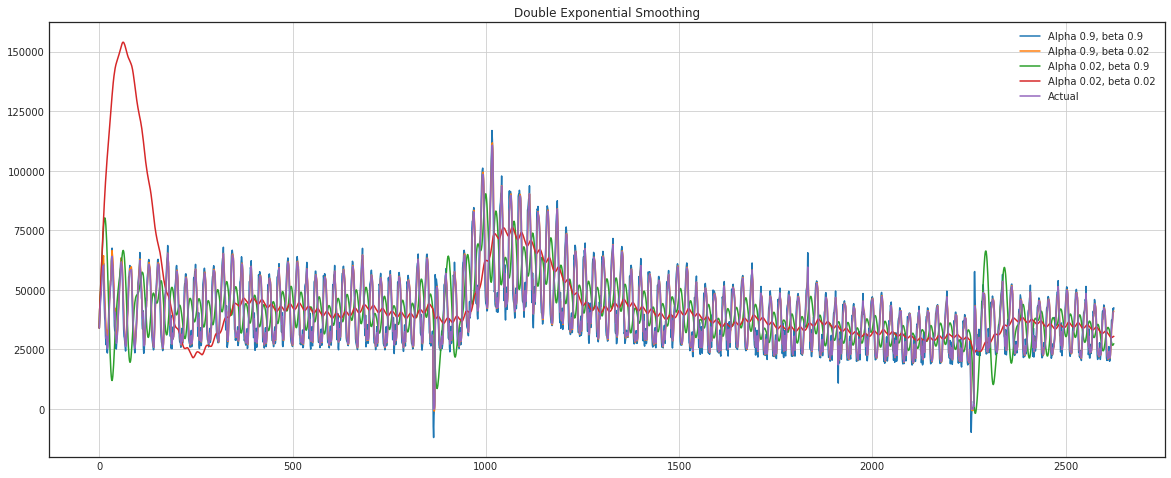

In [106]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset.Users, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.Users.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

## Тройное экспоненциальное сглаживание a.k.a. Holt-Winters

Идея этого метода заключается в добавлении еще одной, третьей, компоненты — сезонности. Соответственно, метод применим только в случае, если ряд этой сезонностью не обделён, что в нашем случае верно. Сезонная компонента в модели будет объяснять повторяющиеся колебания вокруг уровня и тренда, а характеризоваться она будет длиной сезона — периодом, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 7 (например, недельная сезонность), то получим 7 сезонных компонент, по штуке на каждый из дней недели.

$$ \ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})\\ b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}\\ s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}\\ \hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL} $$

Ниже приведен код для построения модели тройного экспоненциального сглаживания, также известного по фамилиям её создателей — Чарльза Хольта и его студента Питера Винтерса.
Дополнительно в модель включен метод Брутлага для построения доверительных интервалов:


$$ \hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}\\ \hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}\\ d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T}, $$

In [107]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

## Кросс-валидация на временных рядах, подбор параметров

Суть достаточно проста — начинаем обучать модель на небольшом отрезке временного ряда, от начала до некоторого $t$, делаем прогноз на $t+n$ шагов вперед и считаем ошибку. Далее расширяем обучающую выборку до $t+n$ значения и прогнозируем с $t+n$ до $t+2*n$, так продолжаем двигать тестовый отрезок ряда до тех пор, пока не упрёмся в последнее доступное наблюдение. В итоге получим столько фолдов, сколько $n$ уместится в промежуток между изначальным обучающим отрезком и всей длиной ряда.

In [108]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [109]:
from scipy.optimize import minimize

data = dataset.Users[:-500] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.006634267064344168 0.0 0.0467652042896729


Передадим полученные оптимальные значения коэффициентов $\alpha$, $\beta$ и $\gamma$ и построим прогноз на 5 дней вперёд (128 часов)

In [110]:
data = dataset.Users
model = HoltWinters(data[:-128], slen = 24*7, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 128, scaling_factor = 2.56)
model.triple_exponential_smoothing()

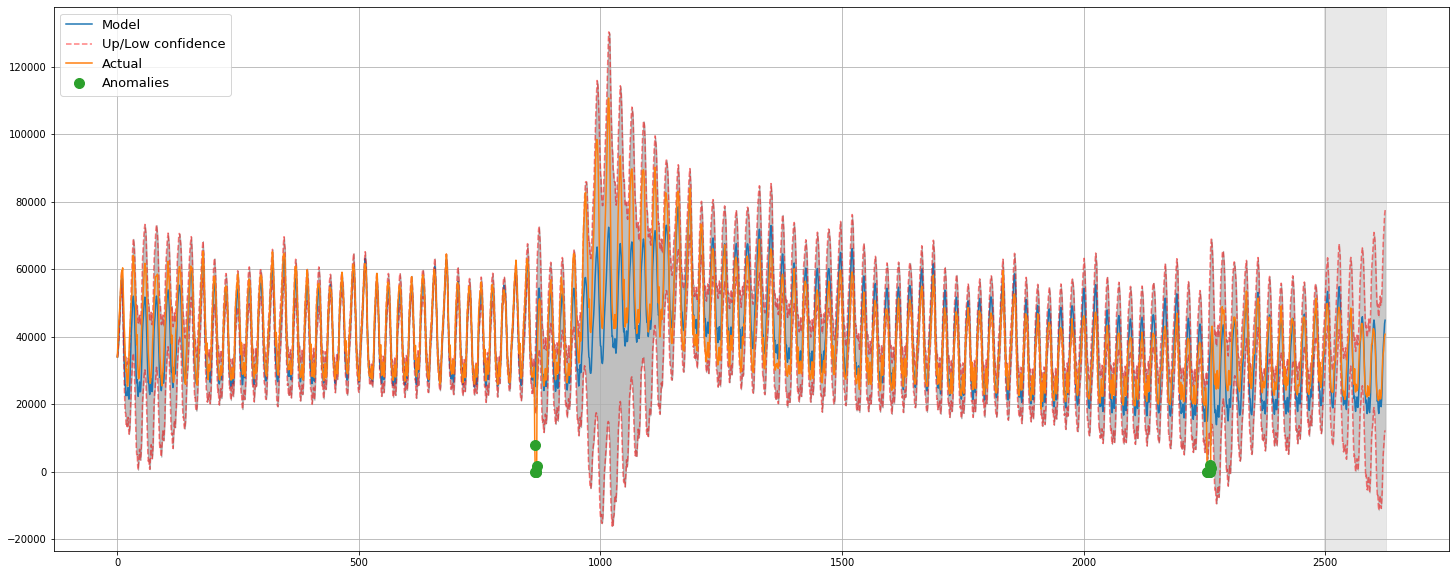

In [111]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

plotHoltWinters()

# Стационарность
Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же гомоскедастичность) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями).

## Избавляемся от нестационарности и строим SARIMA
https://habr.com/ru/post/207160/

In [27]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9


You should consider upgrading via the 'c:\program files\python39\python.exe -m pip install --upgrade pip' command.


c:\python\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Критерий Дики-Фуллера: p=0.190189


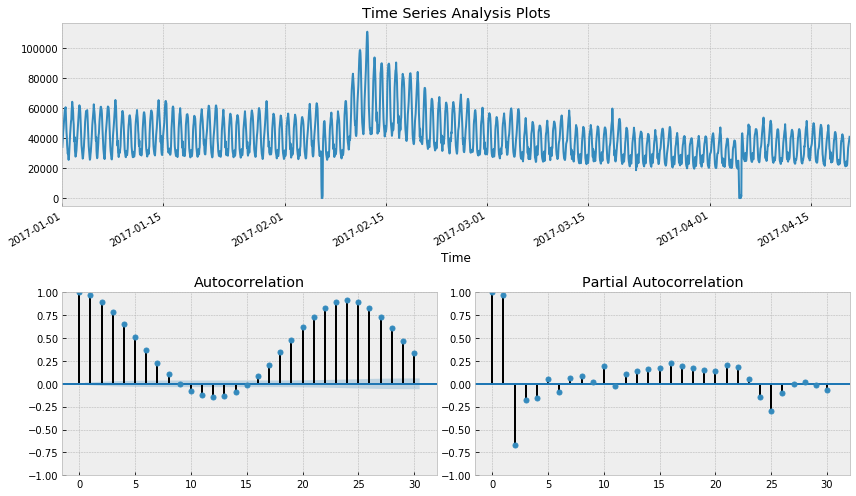

In [112]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(dataset.Users, lags=30)

 Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса.

c:\python\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Критерий Дики-Фуллера: p=0.079760
Оптимальный параметр преобразования Бокса-Кокса: 0.587270


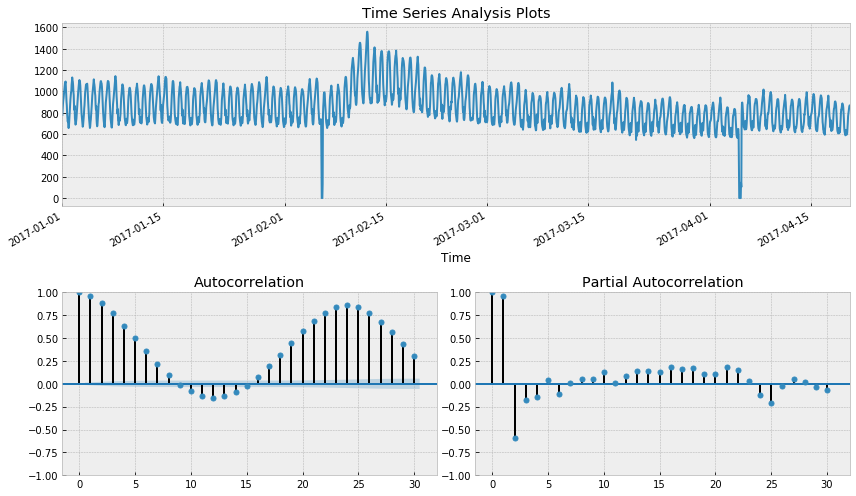

In [113]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = dataset.copy()
data['Users_box'], lmbda = scs.boxcox(data.Users+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.Users_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности ряда. А автокорреляционная функция 

c:\python\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Критерий Дики-Фуллера: p=0.002571


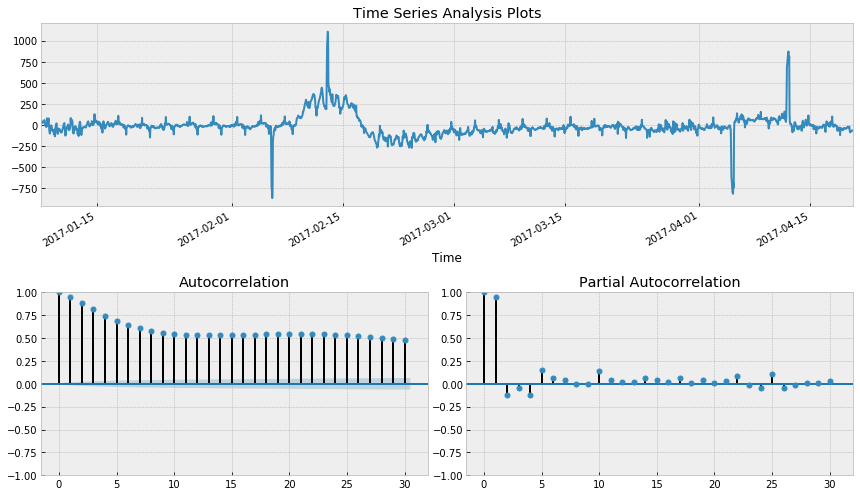

In [114]:
data['Users_box_season'] = data.Users_box - data.Users_box.shift(24*7)
tsplot(data.Users_box_season[24*7:], lags=30)

Критерий Дики-Фуллера теперь отвергает нулевую гипотезу о нестационарности, но автокорреляционная функция всё ещё выглядит нехорошо из-за большого числа значимых лагов. Так как на графике частной автокорреляционной функции значим лишь один лаг, стоит взять еще первые разности, чтобы привести наконец ряд к стационарному виду.

c:\python\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Критерий Дики-Фуллера: p=0.000000


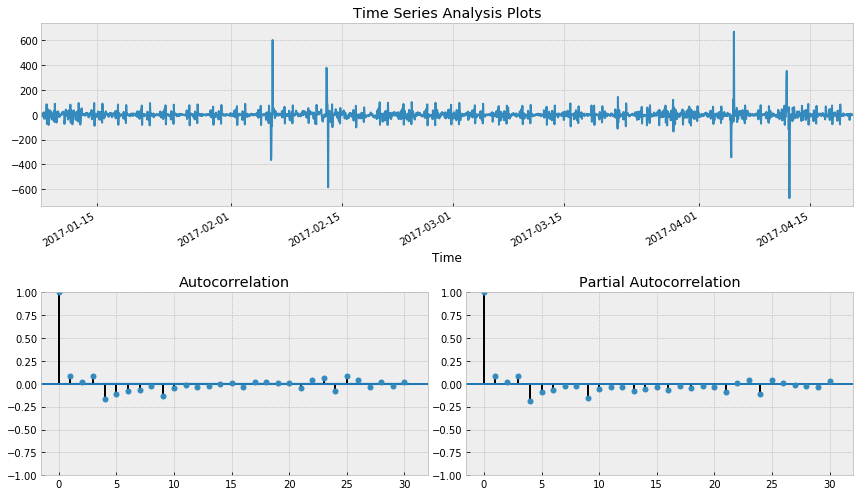

In [115]:
data['Users_box_season_diff'] = data.Users_box_season - data.Users_box_season.shift(1)
tsplot(data.Users_box_season_diff[24*7+1:], lags=30)

Наконец, получили стационарный ряд, по автокорреляционной и частной автокорреляционной функции прикинем параметры для SARIMA модели, на забыв, что предварительно уже сделали первые и сезонные разности.


Начальные приближения Q = 1, P = 4, q = 3, p = 4

In [37]:
ps = range(3, 5)
d=1
qs = range(3, 4)
Ps = range(3, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [ ]:
results = []
best_aic = float("inf")

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.Users_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24*7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

C:\Users\alexe\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\alexe\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
best_model = sm.tsa.statespace.SARIMAX(data.Users_box, order=(4, d, 3), 
                                        seasonal_order=(4, D, 1, 24)).fit(disp=-1)
print(best_model.summary()) 

In [ ]:
tsplot(best_model.resid[24:], lags=30)

In [ ]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+100), lmbda)
forecast = data.arima_model.append(forecast).values[-500:]
actual = data.Users.values[-400:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(data.dropna().Users, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

## Извлечение признаков

Добавлю только про еще один вариант кодирования категориальных признаков – кодирование средним. В нашем случае каждый день недели или час дня можно закодировать сооветствующим средним числом игроков, находившихся в этот день недели или час онлайн. 

In [116]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

Создадим новый датафрейм и добавим в него час, день недели и выходной в качестве категориальных переменных. Для этого переводим имеющийся в датафрейме индекс в формат datetime, и извлекаем из него hour и weekday.

In [117]:
data = pd.DataFrame(dataset)
data.columns = ["y"]

data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

,y,hour,weekday,is_weekend
Time,,,,
2017-01-01 00:00:00,34002,0,6,1
2017-01-01 01:00:00,37947,1,6,1
2017-01-01 02:00:00,41517,2,6,1
2017-01-01 03:00:00,44476,3,6,1
2017-01-01 04:00:00,46234,4,6,1


In [118]:
code_mean(data, 'weekday', "y")

{0: 38730.143229166664,
 1: 38632.828125,
 2: 38128.518229166664,
 3: 39519.035135135135,
 4: 41505.15277777778,
 5: 43717.708333333336,
 6: 43392.14360313316}

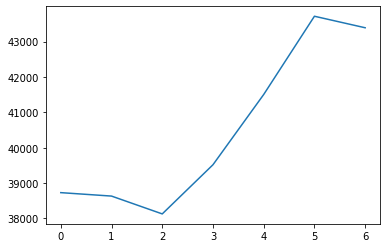

In [119]:
plt.plot(list(code_mean(data, 'weekday', "y").values()))

Помимо перечисленных преобразований для увеличения числа признаков используют и множество других метрик, например, максимальное/минимальное значение, наблюдавшееся в скользящем по ряду окне, медианы, число пиков, взвешенные дисперсии и многое другое. Автоматически этим занимается уже упоминавшаяся в курсе библиотека библиотека tsfresh.


Для удобства все преобразования можно записать в одну функцию, которая сразу же будет возвращать разбитые на трейн и тест датасеты и целевые переменные.

In [145]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

In [146]:
dataset = pd.read_csv('hour_online.csv', index_col=['Time'], parse_dates=['Time'])
dataset.head()

,Users
Time,
2017-01-01 00:00:00,34002
2017-01-01 01:00:00,37947
2017-01-01 02:00:00,41517
2017-01-01 03:00:00,44476
2017-01-01 04:00:00,46234


In [147]:
X_train, X_test, y_train, y_test = prepareData(dataset.Users, test_size=0.3, lag_start=12, lag_end=16)

In [148]:
X_train.head()

,lag_12,lag_13,lag_14,lag_15,is_weekend,weekday_average,hour_average
0,44476.0,41517.0,37947.0,34002.0,1,47361.657795,37372.223684
1,46234.0,44476.0,41517.0,37947.0,1,47361.657795,34212.605263
2,48842.0,46234.0,44476.0,41517.0,1,47361.657795,34159.921053
3,52245.0,48842.0,46234.0,44476.0,1,47361.657795,30956.394737
4,55245.0,52245.0,48842.0,46234.0,1,47361.657795,29487.986842


Применим линейную регрессию

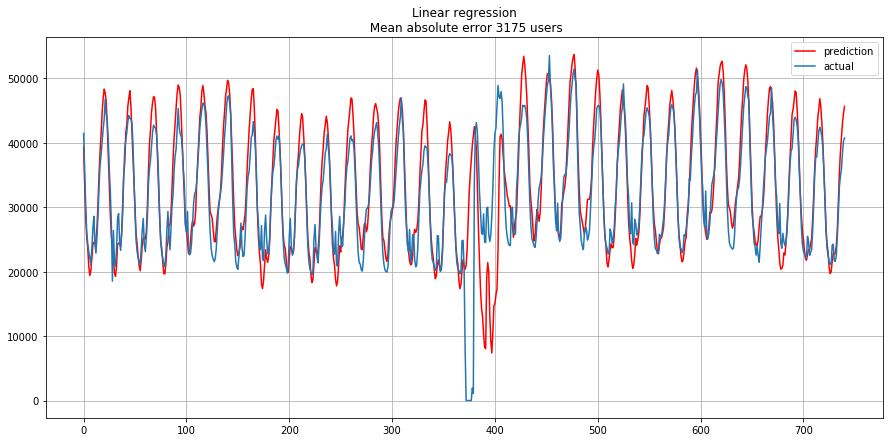

In [150]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(dataset.Users, test_size=0.3, lag_start=12, lag_end=48)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True)

Также можно провести оценку модели на кросс-валидации

In [151]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [152]:
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (1838, 39)
Size of each fold: 367

Splitting the first 2 chunks at 1/2
Size of train + test: (734, 39)

Splitting the first 3 chunks at 2/3
Size of train + test: (1101, 39)

Splitting the first 4 chunks at 3/4
Size of train + test: (1468, 39)

Splitting the first 5 chunks at 4/5
Size of train + test: (1835, 39)


4613.178931508975

Почему бы теперь не попробовать XGBoost

In [155]:
!pip install xgboost

You should consider upgrading via the 'c:\python\python.exe -m pip install --upgrade pip' command.


In [156]:
import xgboost as xgb

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(dataset.Users, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

In [157]:
XGB_forecast(dataset, test_size=0.2, lag_start=5, lag_end=30)

[15:05:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:18

c:\python\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning:

invalid value encountered in subtract



ValueError: could not convert string to float: '-nan(ind)'